# Overview

In [1]:
import os, importlib
import pandas as pd, numpy as np, matplotlib.pyplot as plt

from pathlib import Path


# Initial Data Preparation

In [2]:
# a small piece of code to find the data folder

NOTEBOOK_SCRIPT = os.getcwd()

current = NOTEBOOK_SCRIPT
while 'data' not in os.listdir(current):
    current = Path(current).parent

DATA_FOLDER = os.path.join(current, 'data')

In [3]:
# let's extract all the features needed in the data. 
import data_preparation as dpre
importlib.reload(dpre)


db_file = os.path.join(DATA_FOLDER, 'F24.ML.Assignment.One.data.db')
df_save_file = os.path.join(DATA_FOLDER, 'data.csv')
df = dpre.data_to_df(db_file, 
           df_save_file, 
           overwrite=False # no need to execute the same lengthy query if the .csv file already exists...
           )

In [4]:
df.head()

,order_id,start_prep_date,finish_prep_date,profit,delivery_distance,status_id,planned_prep_time,product_id,store_id,price
0,18671223,2024-05-08 00:01:21,2024-05-08 00:25:12,20.145,3934,F,35.0,99278,3750,26.07
1,18671223,2024-05-08 00:01:21,2024-05-08 00:25:12,20.145,3934,F,35.0,99283,3750,7.11
2,18671223,2024-05-08 00:01:21,2024-05-08 00:25:12,20.145,3934,F,35.0,99285,3750,7.11
3,18671225,2024-05-08 00:02:01,2024-05-08 00:10:29,15.800,560,F,15.0,298529,5863,31.60
4,18671227,2024-05-08 00:01:50,2024-05-08 00:49:19,6.004,4396,F,20.0,399309,8721,30.02


## Observations


* the preparation time (in mintues) which is defined as the difference between finish_prep_data and start_prep_date is common between all items in the same order. In this case it is important to have disjoint sets of orders in the train and test dataset to avoid data leakage. A SOPHITICATED MODEL (SUCH AS NEURAL NETWORK) CAN EASILY MEMORIZE THE ORDER ID, MAP IT TO ITS LABEL.

* if the price + product_id do not provide any useful insights. I will keep only the information on the order-level reducing the number of samples.


# Data Preparation

## Missing data
Before moving to data splitting, it is necessary to make sure the 'fields' needed to compute the label are not missing.

In [5]:
import pandas as pd
import numpy as np
missing_data = np.mean(df.isna(), axis=0)
missing_data

order_id             0.000000
start_prep_date      0.000000
finish_prep_date     0.000000
profit               0.099278
delivery_distance    0.000000
status_id            0.000000
planned_prep_time    0.000004
product_id           0.000000
store_id             0.000000
price                0.100164
dtype: float64

The data has been prepared (with SQL) such that for a single order neither `finish_prep_date` nor `start_prep_date` would be missing and the natural relation `finish_prep_date` > `start_prep_date` is preserved. The label for a given order is the difference of these two values and hence a missing value in one of them would mean a missing label. Imputing missing labels is highly discouraged as it is prone to introduce bias according to [Multivariate Analysis](https://www.drnishikantjha.com/papersCollection/Multivariate%20Data%20Analysis.pdf).

Since `planned_prep_time` is intuitively a very good indicator of the actual preparation time, we will also remove the very few samples with missing `planned_prep_time`. 

In [6]:
importlib.reload(dpre)
samples_with_missing = dpre.samples_with_missing_data(df, columns=['planned_prep_time'], missing_data_rel='or', objective='locate')
print(f"missing ratio: {len(samples_with_missing) / len(df)}") 

# we are barely losing any data...
df = dpre.samples_with_missing_data(df, columns=['planned_prep_time'], missing_data_rel='or', objective='remove')

# prepare the date
df = dpre.prepare_labels(df)
df.head()

missing ratio: 3.6493553413789454e-06


,order_id,start_prep_date,profit,delivery_distance,status_id,planned_prep_time,product_id,store_id,price,y
0,18671223,2024-05-08 00:01:21,20.145,3934,F,35.0,99278,3750,26.07,23.0
1,18671223,2024-05-08 00:01:21,20.145,3934,F,35.0,99283,3750,7.11,23.0
2,18671223,2024-05-08 00:01:21,20.145,3934,F,35.0,99285,3750,7.11,23.0
3,18671225,2024-05-08 00:02:01,15.800,560,F,15.0,298529,5863,31.60,8.0
4,18671227,2024-05-08 00:01:50,6.004,4396,F,20.0,399309,8721,30.02,47.0


In [7]:
## one final check; 'y' is expected to be strictly positive.
print(len(df[df['y'] < 0]))
## no 'y' stricly less than 0, but we still have labels as '0'.
zero_prep_time = df[df['y'] == 0]
print("zero prep time portion: ", len(zero_prep_time) / len(df)) # 0.1% of the data
df = df[df['y'] > 0]

0
zero prep time portion:  0.0011595868914677761


## Split Data

In [8]:
# according to the assignment requirements, the data must be split into train and test with test representing 10% of the data
importlib.reload(dpre)
df_train, df_test = dpre.df_split(df, splits=(0.9, 0.1))
# everything seems to checkout !!!
len(df_train), len(df_test), round(len(df_train) / len(df_test), 4) 

(985287, 109522, 8.9962)

## Impute Missing data:  The price and profit columns


### Price
We can assume that the same product_id is associated with the same price tag.

In [9]:
PRODUCT_PRICE_TRAIN = pd.pivot_table(df_train, values=['price'], index='product_id', aggfunc=['min', 'median', 'mean', 'count', lambda x: x.isna().sum()])
PRODUCT_PRICE_TRAIN

,min,median,mean,count,<lambda>
,price,price,price,price,price
product_id,,,,,
29049,47.40,47.40,47.40,730,84
29060,94.80,94.80,94.80,43,7
29115,31.60,31.60,31.60,17,3
29127,79.00,79.00,79.00,16,2
29139,35.55,35.55,35.55,65,6
...,...,...,...,...,...
1314301,NaN,NaN,NaN,0,1
1314339,NaN,NaN,NaN,0,1


product_ids have Nan prices in certain samples and non-na value in others. We can use the aggregated values to impute the nan values. However, we still have samples without a price value at all.

In [10]:
PRODUCT_PRICE_TRAIN.isna().sum()
# keep pnly the mean price
PRODUCT_PRICE_TRAIN.columns = PRODUCT_PRICE_TRAIN.columns.droplevel(1)
PRODUCT_PRICE_TRAIN = PRODUCT_PRICE_TRAIN.rename(columns={"mean": "mean_price"}).reset_index()
PRODUCT_PRICE_TRAIN = PRODUCT_PRICE_TRAIN[['product_id', 'mean_price']]
PRODUCT_PRICE_TRAIN.head()

,product_id,mean_price
0,29049,47.40
1,29060,94.80
2,29115,31.60
3,29127,79.00
4,29139,35.55


In [11]:
def impute_price(df: pd.DataFrame):
	return pd.merge(df, PRODUCT_PRICE_TRAIN, 
				how='left', 
				left_on='product_id', 
				right_on='product_id')

df_train = impute_price(df_train)

In [12]:
df_train.isna().sum()
# as we can see here the number of Nan 'prices' was reduced from  300k to a mere 1.5k
# I am unlikely to use the exact price of an item.
df_train = df_train.drop(columns=['price']).rename(columns={"mean_price": "price"})

df_test = impute_price(df_test)
df_test = df_test.drop(columns=['price']).rename(columns={"mean_price": "price"})

### Profit 
Unlike the price, the profit is computed across the entire order. We can consider some aggregate across both the store and the product id; basically an estimation of how much profit a specific store makes on a specific product.

In [13]:
# choosing the min, gives us the best estimation of the profit that a certain store makes on a given product.
TRAIN_PROFIT_PER_STORE_AND_PRODUCT = pd.pivot_table(df_train, values=['profit'], index=['store_id', 'product_id'], aggfunc='min')
TRAIN_PROFIT_PER_STORE_AND_PRODUCT = TRAIN_PROFIT_PER_STORE_AND_PRODUCT.rename(columns={"profit": "profit_agg"}) 
TRAIN_PROFIT_PER_STORE_AND_PRODUCT

profit_agg
store_id product_id            
3053     29049            9.480
         29060           26.860
         29115           11.850
         29848            9.875
         30299            2.528
...                         ...
11963    1089865         24.016
         1089883         35.471
         1248477         11.534
         1248503         24.016
11965    1317371         13.430

[68756 rows x 1 columns]

In [14]:
# let's impute now:
def impute_profit(df: pd.DataFrame) -> pd.DataFrame:
	new_df = pd.merge(left=df, right=TRAIN_PROFIT_PER_STORE_AND_PRODUCT, 
				how='left', 
				right_index=True, 
				left_on=['store_id', 'product_id'])

	new_df_agg = pd.pivot_table(new_df, values=['profit_agg'], index='order_id', aggfunc='sum') 

	# merge again 
	new_df = pd.merge(new_df.drop(columns=['profit_agg']), new_df_agg, left_on='order_id', right_index=True)
	
	def impute_by_row(row):
		if np.isnan(row['profit']):
			row['profit'] = row['profit_agg']
		return row
	# impute and then remove the 'profit_agg' column
	return new_df.apply(impute_by_row, axis=1).drop(columns='profit_agg')

df_train = impute_profit(df_train)
df_train.isna().sum()

order_id                0
start_prep_date         0
profit                  0
delivery_distance       0
status_id               0
planned_prep_time       0
product_id              0
store_id                0
y                       0
price                1423
dtype: int64

In [15]:
df_test = impute_profit(df_test)
df_test.isna().sum()

order_id                0
start_prep_date         0
profit                  0
delivery_distance       0
status_id               0
planned_prep_time       0
product_id              0
store_id                0
y                       0
price                1560
dtype: int64

# EDA

## Labels: preparation time

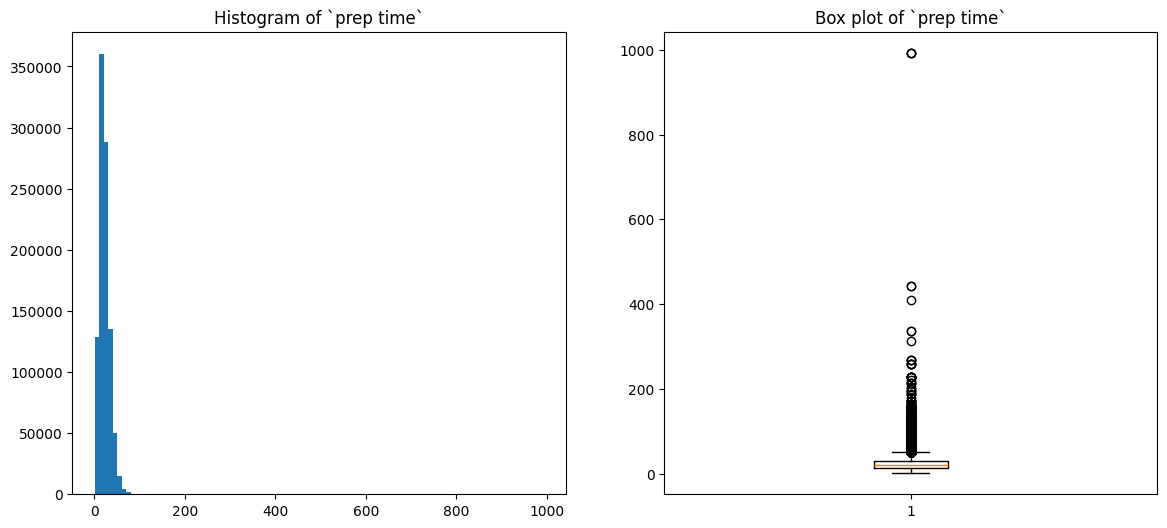

In [16]:
# let's visualize the distribution of labels: both box plot and histograms
import matplotlib.pyplot as plt

y_train = df_train['y']

fig = plt.figure(figsize=(14, 6)) 
fig.add_subplot(1, 2, 1) 

plt.hist(y_train, bins=100)
plt.title("Histogram of `prep time`")

fig.add_subplot(1, 2, 2) 
plt.boxplot(y_train)
plt.title("Box plot of `prep time`")
plt.show()

The histogram clearly demonstrates the skewed distribution of preparation time. Furthermore, the box plot confirms the presence of a relatively large number of outliers. 

In [17]:
import eda
importlib.reload(eda)
mask = eda.iqr_outliers(df_train, 'y', add_column=True)
df_train = df_train[df_train['is_outlier'] == False]
df_train.drop(columns=['is_outlier'], inplace=True)

## Feature clasification: Encoding categorical features


Before applying feature enginnering techniques, it is important to understand the type of data we have: categorial, numerical...

In [18]:
df_train.nunique()

order_id             371561
start_prep_date      361364
profit                18579
delivery_distance     16682
status_id                 2
planned_prep_time        87
product_id            52475
store_id               1409
y                        51
price                  7999
dtype: int64

The features can be classified as follows:

1. Categorical: 
	* product_id
	* store_id
	* order_id: if the product_id does not make a difference, then we will use group by the order id and reduce the number of samples...

2. Continuous:
	* planned prep time
	* price

3. time:
	* start_prep_time: extract the day of the week, the hour, the number of orders a store has received in the last "x" minutes
	* product creation time

Few observations: 

* too many products
* either discard products in general (if most of them were ordered only once or twice) or somehow laverage the frequntly ordered products
* we have few stores which means we can build some 
* the price needs to aggregated across all items in the order


### Product Id and number of products

The number of products is huge. However, due to the low number of features, we do not have much of a choice but to use our features to the fullest. Categorial features with a larger number of unique values are the trickiest to encode. (the product id, although numerical, does not provide any value in and of itself)

After exploring and messing around with the data, I applied a custom target encoding of products_id. I experimented with 2 ideas with common steps:


* common steps: 
	1. consider frequent products bought at least 25 times (25 is arbitrary) 
	2. extract orders with at least one frequent product 

* idea 1: 

	3. clip outliers: according to the iqr method, orders with more than 6 items are outliers, clip number of items to 10 
	4. compute the number of items per order, compute the average order prep time per item (for each order): `y_per_product`
	5. for each product: compute the average / median `y_per_product` for each product
	6. each order will have an estimated `y` as the sum of `y_per_product` of the order items

* idea 2 a bit simpler (yet more effective):

	4. compute the average / median order time for each product
	5. estimate `y` as the maximum of the aggregated values for all products in the order


MAE for idea 1: $\approx 8.9$

MAE for idea 2: $\approx 6.4$

In [19]:
# extract the frequent products from the train data
TRAIN_FREQ_PRODUCTS = eda.select_frequent_orders(df_train, freq_threshold=15)

In [20]:
importlib.reload(eda)
TRAIN_FREQ_PROD_Y_STATS, train_freq_order = eda.build_product_id_prep_time_estimation(df_train)
TRAIN_FREQ_PROD_Y_STATS.head()

,y_prod_mean,y_prod_median
product_id,,
29049,27.820766,27.0
29060,30.960000,31.0
29139,27.913043,27.0
29140,29.978947,29.0
29141,25.901961,26.0


In [21]:
df_est = pd.pivot_table(train_freq_order, 
						index='order_id', 
						values=['y', 'y_prod_mean', 'y_prod_median'], 
						aggfunc='max')

y_freq_train, y_mean_est, y_median_est = df_est['y'], df_est['y_prod_mean'], df_est['y_prod_median']

mse_mean = np.mean(np.abs(y_freq_train.values - y_mean_est.values)) 
mse_median = np.mean(np.abs((y_freq_train.values - y_median_est.values))) 
print(mse_mean, mse_median)

mse_mean = np.sqrt(np.mean((y_freq_train.values - y_mean_est.values) ** 2)) 
mse_median = np.sqrt(np.mean((y_freq_train.values - y_median_est.values)** 2)) 
print(mse_mean, mse_median)

6.5992944165280845 6.400483483636921
8.366970588746284 8.331078101788126


The only caveat so far is the following: 

the statistics have been computed solely on frequent products. Although this set of products (since we are aggregating by the `max` function) should cover the prevailing majority of orders, I still need to consider the case where all products in an order are non-frequent.

The simplest solution is compute the average time for orders with only non-frequent orders and use it to encode products for such orders done as follows: 

Given a dataframe, and a list frequent products, first find the order with at least one frequent product. Join them and compute the `y` estimate from the products. 

Extract all products with non-frequent products, compute their average `y` time and then use it to all of such orders.

In [22]:
from sklearn.impute import SimpleImputer

def encode_product_id(df: pd.DataFrame, non_freq_avg_y: float = None):
	# first let's find the orders with frequent products
	freq_prod_orders_ids = pd.merge(df, TRAIN_FREQ_PROD_Y_STATS, left_on='product_id', right_index=True, how='inner')['order_id'].tolist()

	# filter the order with no frequent items
	non_freq_orders = df[~df['order_id'].isin(freq_prod_orders_ids)]

	# calculate the average prep time for such orders
	if non_freq_avg_y is None:
		non_freq_avg_y = np.mean(non_freq_orders['y']).item()

	print("number of non frequent orders: ", len(non_freq_orders))
	print("total number of orders",len(df))

	# repeat the same join but 'left'
	# this should set the orders with no frequent products to None 
	new_df = pd.merge(df, TRAIN_FREQ_PROD_Y_STATS, left_on='product_id', right_index=True, how='left')
	# drop the 'y_prod_mean'
	new_df.drop(columns=['y_prod_mean'], inplace=True)

	# impute the median with the constant value
	imputer = SimpleImputer(strategy='constant', fill_value=non_freq_avg_y)
	# impute the nan values (for non-freq products) with the 'average value'
	imputed_series = pd.Series(imputer.fit_transform(new_df[['y_prod_median']]).squeeze(), 
							index=new_df.index # make sure to set the index of the series to that of the dataframe to avoid mismatches and hence unexpected nan values
							)

	new_df['y_prod_median'] = imputed_series

	return new_df.drop(columns=['product_id']), non_freq_avg_y

# encode the product_id in the train dataset|
df_train, TRAIN_NON_FREQ_AVG_y= encode_product_id(df_train, non_freq_avg_y=None)

# pass this value to the test split to avoid data leakage
df_test, _ = encode_product_id(df_test, non_freq_avg_y=TRAIN_NON_FREQ_AVG_y)

number of non frequent orders:  127371
total number of orders 965485
number of non frequent orders:  15152
total number of orders 109522


In [23]:
df_train.head()

,order_id,start_prep_date,profit,delivery_distance,status_id,planned_prep_time,store_id,y,price,y_prod_median
0,18671223,2024-05-08 00:01:21,20.145,3934,F,35.0,3750,23.0,26.070000,26.0
1,18671223,2024-05-08 00:01:21,20.145,3934,F,35.0,3750,23.0,7.110000,24.0
2,18671223,2024-05-08 00:01:21,20.145,3934,F,35.0,3750,23.0,7.110000,26.0
3,18671225,2024-05-08 00:02:01,15.800,560,F,15.0,5863,8.0,31.680436,13.0
4,18671227,2024-05-08 00:01:50,6.004,4396,F,20.0,8721,47.0,30.020000,24.0


### Store id

We more 1.4k unique stores. One way to fully laverage the store_id is to compute the average deviation of the actual prep time from the planned one.

In [24]:
importlib.reload(eda)
TRAIN_POPULAR_STORES = eda.select_popular_stores(df_train, popular_threshold=25)
print(len(TRAIN_POPULAR_STORES) / len(df_train['store_id'].unique()))

0.8218594748048261


In [25]:
# let's see how it all goes
importlib.reload(eda)
TRAIN_STORE_TIME_DEVIATION = eda.build_store_id_deviation_estimation(df_train)
# this is super powerful, simply because we can see that store `3053` always gets their orders on point (within +- 2 mins). encoding this information into the model would definitely enhance the performance.
TRAIN_STORE_TIME_DEVIATION 

,y_deviation
store_id,
3053.0,-2.167621
3055.0,-2.086207
3056.0,-4.518987
3058.0,0.258278
3059.0,-8.545918
...,...
11879.0,-2.000000
11883.0,-9.187500
11901.0,-6.882353


In [26]:
def encode_store_id(df: pd.DataFrame, non_pop_store_dev: float = None) -> pd.DataFrame:
	pop_stores_ids = TRAIN_STORE_TIME_DEVIATION.index.tolist()

	# filter orders from non-popular stores
	non_pop_orders = df[~df['order_id'].isin(pop_stores_ids)]

	# compute the deviation
	if non_pop_store_dev is None:
		non_pop_store_dev = np.mean(non_pop_orders['y'] - df['planned_prep_time']).item()

	new_df = pd.merge(df, TRAIN_STORE_TIME_DEVIATION, left_on='store_id', right_index=True, how='left')
	# impute the missing vaue

	imputer = SimpleImputer(strategy='constant', fill_value=non_pop_store_dev)
	# impute the nan values (for non-freq products) with the 'average value'
	imputed_series = pd.Series(imputer.fit_transform(new_df[['y_deviation']]).squeeze(), 
							index=new_df.index # make sure to set the index of the series to that of the dataframe to avoid mismatches and hence unexpected nan values
							)
	new_df['y_deviation'] = imputed_series

	# drop the 'store_id' feature
	return new_df.drop(columns=['store_id']), non_pop_store_dev

df_train, TRAIN_NON_POP_DEV = encode_store_id(df_train)
df_test, _ = encode_store_id(df_test, TRAIN_NON_POP_DEV)

# Train Data Final Form

All we have done so far revolved around preparing the features: mainly imputing as much of the `price` and `profit` features and trying to embed as much information in the encoding of the `store_id` and `product_id` features.


In [27]:
df_train.head()

,order_id,start_prep_date,profit,delivery_distance,status_id,planned_prep_time,y,price,y_prod_median,y_deviation
0,18671223,2024-05-08 00:01:21,20.145,3934,F,35.0,23.0,26.070000,26.0,-2.559809
1,18671223,2024-05-08 00:01:21,20.145,3934,F,35.0,23.0,7.110000,24.0,-2.559809
2,18671223,2024-05-08 00:01:21,20.145,3934,F,35.0,23.0,7.110000,26.0,-2.559809
3,18671225,2024-05-08 00:02:01,15.800,560,F,15.0,8.0,31.680436,13.0,-3.562679
4,18671227,2024-05-08 00:01:50,6.004,4396,F,20.0,47.0,30.020000,24.0,-1.442516


In [28]:
importlib.reload(eda)
def final_data_transform(df: pd.DataFrame) -> pd.DataFrame:
	item_level_data = pd.pivot_table(df, index='order_id', values=['y_deviation', 'y_prod_median', 'price'], aggfunc=['max', 'sum'])

	# extract the information needed: 'max of y_deviation (the same across orders), max y_prod_median, and the sum of prices
	item_level_data = item_level_data.loc[:, [('max', 'y_deviation'), ('max', 'y_prod_median'), ('sum', 'price')]]
	item_level_data.columns = item_level_data.columns.droplevel(0)

	# merge the item_level_data with the dataframe
	df_ = pd.merge(df.drop(columns=['y_deviation', 'y_prod_median', 'price']), item_level_data, how='inner', left_on='order_id', right_index=True)
	df_.rename(columns={"y_prod_median": "y_estimate"}, inplace=True)
	df_.drop_duplicates(inplace=True)

	# remove the order_id + extract some time features 
	df_.drop(columns=['order_id', 'status_id'], inplace=True)

	return eda.extract_prep_time_features(df_)

df_train = final_data_transform(df_train)
df_test = final_data_transform(df_test)

In [29]:
df_train, y_train = df_train, df_train.pop('y')
df_test, y_test = df_test, df_test.pop('y')

In [30]:
df_train.to_csv(os.path.join(DATA_FOLDER, 'train.csv'), index=False)
y_train.to_csv(os.path.join(DATA_FOLDER, 'y_train.csv'), index=False)

df_test.to_csv(os.path.join(DATA_FOLDER, 'test.csv'), index=False)
y_test.to_csv(os.path.join(DATA_FOLDER, 'y_test.csv'), index=False)

In [52]:
from typing import List, Optional
from sklearn.preprocessing import StandardScaler, RobustScaler

def scale_num_features(df: pd.DataFrame, num_features: Optional[List[str]] = None, scaler: RobustScaler= None):
	if num_features is None:
		num_features = ['profit', 'delivery_distance', 'price']

	# set the type of the numerical features to float
	df.loc[:, num_features] = df.loc[:, num_features].astype(float)

	df_to_scale = df.loc[:, num_features]

	if scaler is None:
		scaler = RobustScaler()
		# fit the scaler
		num_feats_scaled = scaler.fit_transform(df_to_scale)

	else:
		# then the we will use the 'transform' method without fitting
		num_feats_scaled = scaler.transform(df_to_scale)

	# set the scaled features in the new dataframe
	df.loc[:, num_features] = num_feats_scaled
	return df, scaler

df_train_, TRAIN_SCALER = scale_num_features(df_train)
df_test_, _ = scale_num_features(df_test, scaler=TRAIN_SCALER)

In [53]:
df_train_.dtypes
df_test_.dtypes

profit               float64
delivery_distance    float64
planned_prep_time    float64
y_deviation          float64
y_estimate           float64
price                float64
order_hour             int32
order_day              int64
dtype: object

In [54]:
df_train_.head()

,profit,delivery_distance,planned_prep_time,y_deviation,y_estimate,price,order_hour,order_day
0,-0.226908,0.109560,35.0,-2.559809,26.000000,-0.436892,0,2
3,-0.337349,-0.796455,15.0,-3.562679,13.000000,-0.569152,0,2
4,-0.586345,0.233620,20.0,-1.442516,24.000000,-0.594659,0,2
5,0.285141,0.529807,30.0,-5.926710,21.799648,0.478846,0,2
9,2.380723,0.506176,25.0,-0.803828,23.000000,1.310799,0,2


In [55]:
df_test_.head()

,profit,delivery_distance,planned_prep_time,y_deviation,y_estimate,price,order_hour,order_day
0,-0.188755,-0.195757,25.0,-2.046578,25.500000,0.606795,0,2
2,-0.114458,0.821697,15.0,-1.494090,21.799648,0.169903,0,2
6,0.287550,-0.546724,25.0,-0.366591,25.000000,-0.280339,0,2
8,-0.184739,-0.926692,30.0,-2.041570,29.000000,0.794941,0,2
14,0.112450,1.644468,30.0,-2.559809,27.000000,-0.412621,0,2


# Modeling

In [7]:
# df_train = pd.read_csv(os.path.join(DATA_FOLDER, 'train.csv'))
# y_train = pd.read_csv(os.path.join(DATA_FOLDER, 'y_train.csv'))

# df_test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))
# y_test = pd.read_csv(os.path.join(DATA_FOLDER, 'y_test.csv'))

In [56]:
import models
importlib.reload(models)

from sklearn.linear_model import LinearRegression, Ridge, Lasso
lr, lr1, lr2 = LinearRegression(), Lasso(alpha=1), Ridge(alpha=1), 
models_res = {}
for m in [lr, lr1, lr2]:
	m_name = models._extract_model_name_from_cls(m)
	models_res[m_name] = models.pipeline(df_train_, y_train, df_test_, y_test, m)
	print(m_name, models_res[m_name][1:])

LinearRegression ({'train_rmse': 7.5872, 'train_mae': 5.7857, 'train_r2': 0.4318}, {'test_rmse': 9.5817, 'test_mae': 6.1664, 'test_r2': 0.3662})
Lasso ({'train_rmse': 7.6567, 'train_mae': 5.8375, 'train_r2': 0.4214}, {'test_rmse': 9.6566, 'test_mae': 6.2173, 'test_r2': 0.3563})
Ridge ({'train_rmse': 7.5872, 'train_mae': 5.7857, 'train_r2': 0.4318}, {'test_rmse': 9.5817, 'test_mae': 6.1664, 'test_r2': 0.3662})


In [57]:
from sklearn.tree import DecisionTreeRegressor
DecReg = DecisionTreeRegressor(max_depth=4, random_state=0)
models_res[models._extract_model_name_from_cls(DecReg)] = models.pipeline(df_train_, y_train, df_test_, y_test, DecReg)

In [58]:
models_res[models._extract_model_name_from_cls(DecisionTreeRegressor())]

(DecisionTreeRegressor(max_depth=4, random_state=0),
 {'train_rmse': 7.7322, 'train_mae': 5.9252, 'train_r2': 0.4099},
 {'test_rmse': 9.7648, 'test_mae': 6.3213, 'test_r2': 0.3417})

In [62]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=20, max_depth=4)
models_res[models._extract_model_name_from_cls(rf)] = models.pipeline(df_train_, y_train, df_test_, y_test, rf)

In [63]:
models_res[models._extract_model_name_from_cls(RandomForestRegressor())]

(RandomForestRegressor(max_depth=4, n_estimators=20),
 {'train_rmse': 7.7259, 'train_mae': 5.9193, 'train_r2': 0.4109},
 {'test_rmse': 9.7589, 'test_mae': 6.3146, 'test_r2': 0.3425})